In [9]:
from openai import OpenAI
import openai
import os 
import pandas as pd
import json
# 1. Upload training file
client = OpenAI(api_key=os.getenv("OPENAI_API"))

In [17]:
model_name = "gpt-3.5-turbo"

# I. Problem

**I requested guidance from the LLM model on utilizing TD_VectorDistance but response is incorrect**

In [53]:
system_content = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct teradatasql query to run, then look at the results of the query and return the answer.
"""

question = """
How to using Teradata's TD_VectorDistance to calculate distance between following two table : 
    CREATE TABLE "UserHistory" (
    	"Userid" INTEGER NOT NULL, 
    	"CallDuration" DECIMAL(9, 7) NOT NULL, 
    	"DataCounter" DECIMAL(3, 1) NOT NULL, 
    	"SMS" DECIMAL(3, 1) NOT NULL
    )
    
    /*
    3 rows from UserHistory table:
    Userid	CallDuration	DataCounter	SMS
    4	0.0100000	0.4	0.2
    1	0.0000333	0.2	0.1
    3	1.0000000	0.8	0.9
    */
    
    
    CREATE TABLE "UserHistoryReference" (
    	"Userid" INTEGER NOT NULL, 
    	"CallDuration" DECIMAL(9, 7) NOT NULL, 
    	"DataCounter" DECIMAL(3, 1) NOT NULL, 
    	"SMS" DECIMAL(3, 1) NOT NULL
    )
    
    /*
    3 rows from UserHistoryReference table:
    Userid	CallDuration	DataCounter	SMS
    6	0.8300000	0.3	0.6
    5	0.9300000	0.4	0.7
    7	0.7300000	0.5	0.7
    */
"""

result = client.chat.completions.create(
    model=model_name,
    messages=[
    {"role": "system", "content": system_content},
    {"role": "user", "content": question}
  ]
)

In [54]:
print(result.choices[0].message.content)

To calculate the distance between the two tables using Teradata's TD_VectorDistance function, you can use the following query:

```sql
SELECT
    Userid,
    TD_VectorDistance(
        CAST(CallDuration AS FLOAT),
        CAST(DataCounter AS FLOAT),
        CAST(SMS AS FLOAT),
        CAST(CallDuration AS FLOAT),
        CAST(DataCounter AS FLOAT),
        CAST(SMS AS FLOAT)
    ) AS Distance
FROM
    UserHistory CROSS JOIN UserHistoryReference
```

This query uses the TD_VectorDistance function to calculate the distance between each row in the "UserHistory" table and each row in the "UserHistoryReference" table. The result set will contain the userid and the distance between the corresponding rows.

Note: In order to use the TD_VectorDistance function, the values need to be cast as FLOAT.


# II. Fine Tuning

In [20]:
def generate_training_examples(df, out_path):
    """
    Generate data used for fine-tuning the model. 
    Please note that the training data format varies based on the model type. 
    This function is work well for model name 'gpt-3.5-turbo.'"

    Output : jsonl file
    """
    training_examples = []
    
    # Create training examples in the format required for GPT-3.5 fine-tuning
    for index, row in df.iterrows():
        training_example = {
            "messages": [
                {"role": "system", "content": row['system_message'].strip()},
                {"role": "user", "content": row['prompt']},
                {"role": "assistant", "content": row['response']}
            ]
        }
        training_examples.append(training_example)

    with open(out_path, 'w') as f:
        for example in training_examples:
            f.write(json.dumps(example) + '\n')
            
    # return training_examples

## 2.1 Prepare Fine-Tuning Data

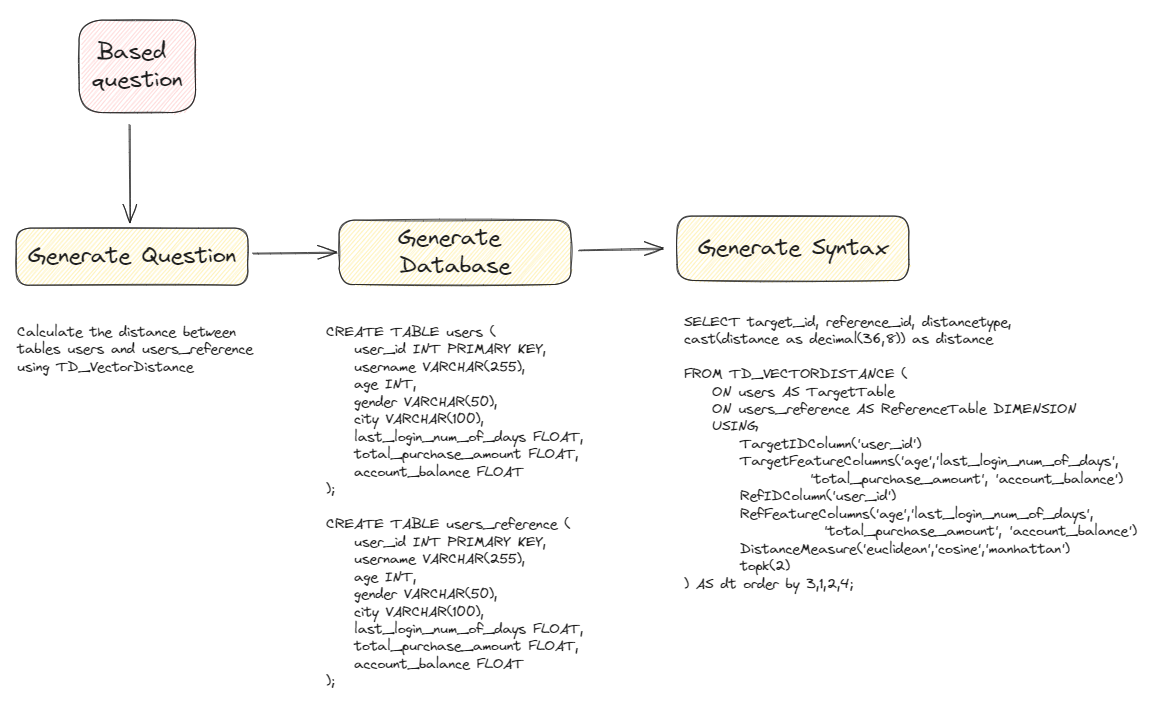

### Step 1. Prepare prompts

**Prepare user question**

In [21]:
user_queries = [
    "Calculate the distance between tables users and users_reference using TD_VectorDistance.",
    "Use TD_VectorDistance to find the distance between vectors in tables orders and orders_reference.",
    "Compute the distance from tables products to products_reference using TD_VectorDistance.",
    "Apply TD_VectorDistance to determine the distance between vectors in tables products and products_reference."
    "Find the vector distance between tables customers and customers_reference with TD_VectorDistance."
    "Execute TD_VectorDistance to measure the distance from tables employees to employees_reference.",
    "Determine the TD_VectorDistance between tables invoices and invoices_reference for vector comparison.",
    "Get the distance metrics for vectors in tables categories and categories_reference using TD_VectorDistance.",
    "Utilize TD_VectorDistance for calculating the distance between tables payments and payments_reference.",
    "Fetch the TD_VectorDistance results for vectors in tables suppliers and suppliers_reference.",
    "Request the distance calculation using TD_VectorDistance for tables reviews and reviews_reference.",
    "Retrieve the vector distance information between tables addresses and addresses_reference with TD_VectorDistance.",
    "Compute vector distances between tables transactions and transactions_reference using TD_VectorDistance.",
    "Use TD_VectorDistance to analyze the distance between vectors in tables departments and departments_reference.",
    "Calculate the TD_VectorDistance between tables inventory and inventory_reference for vector analysis.",
    "Find the vector distance results between tables vendors and vendors_reference using TD_VectorDistance.",
    "Execute the TD_VectorDistance function to determine the distance between tables shipments and shipments_reference.",
    "Request TD_VectorDistance to calculate the distance from tables messages to messages_reference.",
    "Measure the vector distance between tables events and events_reference using TD_VectorDistance.",
    "Obtain TD_VectorDistance results for vector distances between tables tasks and tasks_reference.",
]

**Prepare DB relevant to user question**

*When a user asks a question to calculate TD_VectorDistance, they must also provide the structure of two tables. This function helps automatically generate the table structure mentioned by the user in the prompt.*

In [24]:
def generate_db(user_queries):

    system_content = """
    You are an assistant that helps create SQL syntax to generate tables. 
    The user's inquiry specifies the desired table name, and based on that, you will create 2 table mentioned with the same column.
    At least 8 relevant columns, with at least 5 columns set as Float Type for the specified table. Note that only return SQL syntax without any explain
    
    For example : 
    Input : 
    "Calculate the distance between tables customer and customer_reference using TD_VectorDistance."
    
    Output : 
    CREATE TABLE customer (
        customer_id INT PRIMARY KEY,
        age INT,
        address VARCHAR(255),
        login_time INT,
        last_login_num_of_date Float,
        purchase_amount INT,
    );
    
    CREATE TABLE customer_reference (
        customer_id INT PRIMARY KEY,
        age INT,
        address VARCHAR(255),
        login_time INT,
        last_login_num_of_date Float,
        purchase_amount INT,
    );"""
        
    db_structure = []
    
    for question in user_queries:
        result = client.chat.completions.create(
            model=model_name,
            messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": question}
          ]
        )
        db_structure.append(result.choices[0].message.content)

    return db_structure

In [25]:
db_query = generate_db(user_queries)

In [49]:
prompts = ["{} \r\n{}".format(str(x), str(y)) for x, y in zip(user_queries, db_query)]
print(prompts[0])

Calculate the distance between tables users and users_reference using TD_VectorDistance. 
CREATE TABLE users (
    user_id INT PRIMARY KEY,
    first_name VARCHAR(255),
    last_name VARCHAR(255),
    age INT,
    gender VARCHAR(10),
    height FLOAT,
    weight FLOAT,
    location_x FLOAT,
    location_y FLOAT
);

CREATE TABLE users_reference (
    user_id INT PRIMARY KEY,
    first_name VARCHAR(255),
    last_name VARCHAR(255),
    age INT,
    gender VARCHAR(10),
    height FLOAT,
    weight FLOAT,
    location_x FLOAT,
    location_y FLOAT
);


### Step 2. Prepare response content

In [27]:
def generate_td_syntax(db_structure):

    system_content = """
    You are an assistant that helps create Teradata's TD_VectorDistance Syntax.
    The user's will input two table name, based on that, create TD_VectorDistance. Note that do not use VARCHAR column in TD_VectorDisstance function.
    Note that only return output without any explaination.
    
    For example : 
    Input : 
            CREATE TABLE users (
            user_id INT PRIMARY KEY,
            username VARCHAR(255),
            age INT,
            gender VARCHAR(50),
            city VARCHAR(100),
            last_login_num_of_days FLOAT,
            total_purchase_amount FLOAT,
            account_balance FLOAT
        );
        
        CREATE TABLE users_reference (
            user_id INT PRIMARY KEY,
            username VARCHAR(255),
            age INT,
            gender VARCHAR(50),
            city VARCHAR(100),
            last_login_num_of_days FLOAT,
            total_purchase_amount FLOAT,
            account_balance FLOAT
        );
    
    Output : 
        SELECT target_id, reference_id, distancetype, cast(distance as decimal(36,8)) as distance FROM TD_VECTORDISTANCE (
            ON users AS TargetTable
            ON users_reference AS ReferenceTable DIMENSION
            USING
                TargetIDColumn('user_id')
                TargetFeatureColumns('age','last_login_num_of_days','total_purchase_amount', 'account_balance')
                RefIDColumn('user_id')
                RefFeatureColumns('age','last_login_num_of_days','total_purchase_amount', 'account_balance')
                DistanceMeasure('euclidean','cosine','manhattan')
                topk(2)
        ) AS dt order by 3,1,2,4;
    """
        
    td_syntax = []
    
    for db in db_structure:
        result = client.chat.completions.create(
            model=model_name,
            messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": db}
          ]
        )
        td_syntax.append(result.choices[0].message.content)

    return td_syntax

In [28]:
td_syntax = generate_td_syntax(db_query)

In [29]:
print(td_syntax[0])

SELECT target_id, reference_id, distancetype, cast(distance as decimal(36,8)) as distance FROM TD_VECTORDISTANCE (
    ON users AS TargetTable
    ON users_reference AS ReferenceTable DIMENSION
    USING
        TargetIDColumn('user_id')
        TargetFeatureColumns('age','height','weight','location_x','location_y')
        RefIDColumn('user_id')
        RefFeatureColumns('age','height','weight','location_x','location_y')
        DistanceMeasure('euclidean','cosine','manhattan')
        topk(2)
) AS dt order by 3,1,2,4;


### Step 3. Export fine-tuning

In [50]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct teradatasql query to run, then look at the results of the query and return the answer.
"""

df = pd.DataFrame({
    'prompt': prompts,
    'response': td_syntax,
    'system_message': [system_message] * len(prompts)
})

In [51]:
df.head(3)

,prompt,response,system_message
0,Calculate the distance between tables users an...,"SELECT target_id, reference_id, distancetype, ...",\nYou are an agent designed to interact with a...
1,Use TD_VectorDistance to find the distance bet...,"SELECT target_id, reference_id, distancetype, ...",\nYou are an agent designed to interact with a...
2,Compute the distance from tables products to p...,"SELECT target_id, reference_id, distancetype, ...",\nYou are an agent designed to interact with a...


In [52]:
training_file_path = "./teradata_syntax_finetune.jsonl"

generate_training_examples(df, out_path=training_file_path)

## 2.2 Fine-Tune

### Step 1. Upload fine-tune data

In [136]:
train_file = client.files.create(
  file=open(training_file_path, "rb"),
  purpose="fine-tune"
)

### Step 2. Run fine-tuning job

In [ ]:
client.fine_tuning.jobs.create(
  training_file=train_file.id, 
  model='gpt-3.5-turbo'
)

In [55]:
fine_tune_model_id = "" # After few minutes, above code will return model_id, copy and pasted here

# III. Test

In [153]:
system_content = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct teradatasql query to run, then look at the results of the query and return the answer.
"""

question = """
How to using Teradata's TD_VectorDistance to calculate distance between following two table : 
    CREATE TABLE "UserHistory" (
    	"Userid" INTEGER NOT NULL, 
    	"CallDuration" DECIMAL(9, 7) NOT NULL, 
    	"DataCounter" DECIMAL(3, 1) NOT NULL, 
    	"SMS" DECIMAL(3, 1) NOT NULL
    )
    
    /*
    3 rows from UserHistory table:
    Userid	CallDuration	DataCounter	SMS
    4	0.0100000	0.4	0.2
    1	0.0000333	0.2	0.1
    3	1.0000000	0.8	0.9
    */
    
    
    CREATE TABLE "UserHistoryReference" (
    	"Userid" INTEGER NOT NULL, 
    	"CallDuration" DECIMAL(9, 7) NOT NULL, 
    	"DataCounter" DECIMAL(3, 1) NOT NULL, 
    	"SMS" DECIMAL(3, 1) NOT NULL
    )
    
    /*
    3 rows from UserHistoryReference table:
    Userid	CallDuration	DataCounter	SMS
    6	0.8300000	0.3	0.6
    5	0.9300000	0.4	0.7
    7	0.7300000	0.5	0.7
    */
"""

result = client.chat.completions.create(
    model=fine_tune_model_id,
    messages=[
    {"role": "system", "content": system_content},
    {"role": "user", "content": question}
  ]
)

In [154]:
print(result.choices[0].message.content)


SELECT target_id, reference_id, distancetype, cast(distance as decimal(36,8)) as distance FROM TD_VECTORDISTANCE (
    ON UserHistory AS TargetTable
    ON UserHistoryReference AS ReferenceTable DIMENSION
    USING
        TargetIDColumn('Userid')
        TargetFeatureColumns('CallDuration', 'DataCounter', 'SMS')
        RefIDColumn('Userid')
        RefFeatureColumns('CallDuration', 'DataCounter', 'SMS')
        DistanceMeasure('euclidean', 'cosine', 'manhattan')
        topk(2)
) AS dt order by 3,1,2,4;
